# Цели и задачи

__Цель__: <br/>
1 Оптимизация производственных расходов. <br/>
1.1 Уменьшение потребления электроэнергии на этапе обработки стали. <br/>
_Задачи:_ <br/>
1.1.1 Построение прототипа модели, которая будет предсказывать температуру стали.

__Критерии качества:__
- MAE $\le $ 6.8;
- требований к скорости обучения и предсказания не задано;
- требований к интерпретируемости модели не задано.

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split,
                                    cross_val_score,
                                    GridSearchCV)

from sklearn.metrics import (mean_absolute_error,
                             make_scorer)

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from catboost import Pool
from catboost import CatBoostRegressor

# Глобальные переменные/константы

In [2]:
# Путь для загрузки данных
PATH = 'https://code.s3.yandex.net/datasets/'

RANDOM_SEED = 280823

# Загрузка данных

In [3]:
# Загрузчик

def loader(file_name):
    try:
        df = pd.read_csv(file_name)
        print('загружен из "локального" файла')
        
    except:
        df = pd.read_csv(PATH + file_name)
        print('загружен из "сетевого" файла')
        
    return df

## данные об электродах

In [4]:
data_arc_new = loader('data_arc_new.csv') 

загружен из "локального" файла


## данные о подаче сыпучих материалов (объём)

In [5]:
data_bulk_new = loader('data_bulk_new.csv')

загружен из "локального" файла


## данные о подаче сыпучих материалов (время)

In [6]:
data_bulk_time_new = loader('data_bulk_time_new.csv')

загружен из "локального" файла


## данные о продувке сплава газом

In [7]:
data_gas_new = loader('data_gas_new.csv')

загружен из "локального" файла


## результаты измерения температуры

In [8]:
data_temp_new = loader('data_temp_new.csv')

загружен из "локального" файла


## данные о проволочных материалах (объём)

In [9]:
data_wire_new = loader('data_wire_new.csv')

загружен из "локального" файла


## данные о проволочных материалах (время)

In [10]:
data_wire_time_new = loader('data_wire_time_new.csv')

загружен из "локального" файла


# Исследовательский анализ данных

## данные об электродах

In [11]:
data_arc_new.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460


- Названия столцов оставим без изменений

In [12]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


- Пропуски отсутсвуют.

In [13]:
# Полные дубли

data_arc_new.duplicated().sum()

0

In [14]:
# количество партий

num_of_parties = data_arc_new['key'].nunique()
num_of_parties

3214

In [15]:
# преобразуем столбцы начала и конца нагрева к типу данных - дата/время

data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [16]:
# оценим даты начала и окончания

def dt_min_max(df_):
    print(f'минимальная дата: {df_.min()}')
    print(f'максимальная дата: {df_.max()}')
    print(f'временной интервал: {df_.max() - df_.min()}')

In [17]:
dt_min_max(data_arc_new['Начало нагрева дугой'])

минимальная дата: 2019-05-03 11:02:14
максимальная дата: 2019-09-06 17:24:54
временной интервал: 126 days 06:22:40


In [18]:
dt_min_max(data_arc_new['Конец нагрева дугой'])

минимальная дата: 2019-05-03 11:06:02
максимальная дата: 2019-09-06 17:26:15
временной интервал: 126 days 06:20:13


- временные интервалы совпадают

In [19]:
# посчитаем количество итераций в партиях

data_arc_group = pd.DataFrame(data_arc_new.groupby('key')['key'].count())\
    .rename(columns={'key':'Количество итераций'})
data_arc_group.head(3)

,Количество итераций
key,
1,5
2,4
3,5


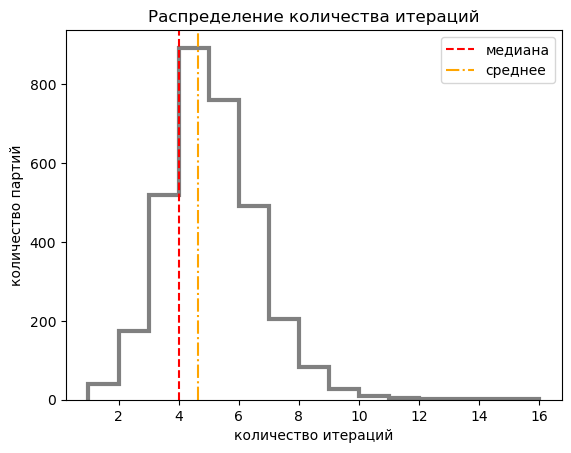

In [20]:
# график распределения количества итераций

data_arc_group['Количество итераций'].hist(bins=15, histtype='step', linewidth=3, grid=False, color='grey')
plt.title('Распределение количества итераций')
plt.xlabel('количество итераций')
plt.ylabel('количество партий')
plt.axvline(data_arc_group['Количество итераций'].median(), c='red', linestyle='--', label='медиана')
plt.axvline(data_arc_group['Количество итераций'].mean(), c='orange', linestyle='-.', label='среднее')
plt.legend();

- видим смещение вправо

In [21]:
# оценим длительность нагрева в секундах

data_arc_new['Длительность нагрева секунд'] = (data_arc_new['Конец нагрева дугой'] -
                                        data_arc_new['Начало нагрева дугой'])\
                                        .dt.seconds

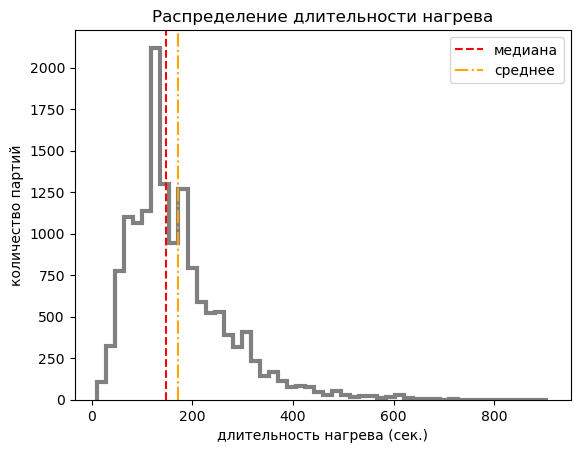

In [22]:
# график распрделения длительности нагрева

data_arc_new['Длительность нагрева секунд'].hist(bins=50, histtype='step', linewidth=3, grid=False, color='grey')

plt.title('Распределение длительности нагрева')
plt.xlabel('длительность нагрева (сек.)')
plt.ylabel('количество партий')
plt.axvline(data_arc_new['Длительность нагрева секунд'].median(), c='red', linestyle='--', label='медиана')
plt.axvline(data_arc_new['Длительность нагрева секунд'].mean(), c='orange', linestyle='-.', label='среднее')
plt.legend();

- видим смещение вправо

In [23]:
# общее время нагрева

data_arc_group = pd.merge(data_arc_group,
         data_arc_new.groupby('key')['Длительность нагрева секунд'].sum(),
        on='key').rename(columns={'Длительность нагрева секунд': 'Длительность нагрева общая секунд'})

In [24]:
data_arc_group.head(3)

,Количество итераций,Длительность нагрева общая секунд
key,,
1,5,1098
2,4,811
3,5,655


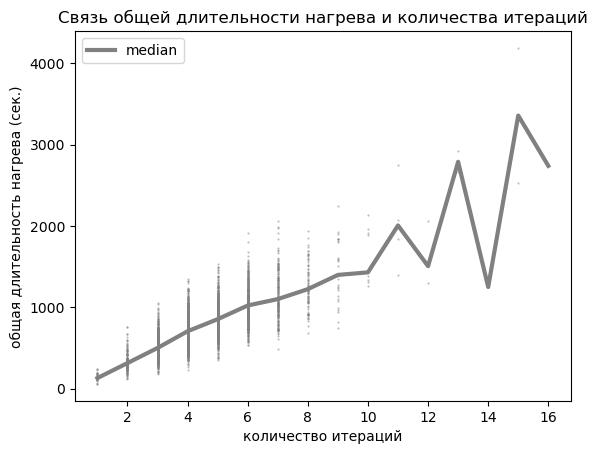

In [25]:
# график - связь количества итераций нагрева партии и общей длительности

# точечный график
plt.scatter(data_arc_group['Количество итераций'], data_arc_group['Длительность нагрева общая секунд'],
           s=.3, c='grey', alpha=0.5)

# линейный график
plt.plot(data_arc_group.groupby('Количество итераций')['Длительность нагрева общая секунд'].median(),
        c='grey', label='median', linewidth=3)

plt.legend()
plt.title('Связь общей длительности нагрева и количества итераций')
plt.xlabel('количество итераций')
plt.ylabel('общая длительность нагрева (сек.)');

- видим рост общей длительности нагрева с ростом количества итераций;
- увеличение размаха колебаний можно объяснить сокращением количества значений.

In [26]:
data_arc_group[['Количество итераций', 'Длительность нагрева общая секунд']].corr(method='spearman')

,Количество итераций,Длительность нагрева общая секунд
Количество итераций,1.000000,0.756825
Длительность нагрева общая секунд,0.756825,1.000000


- сильная положительная связь

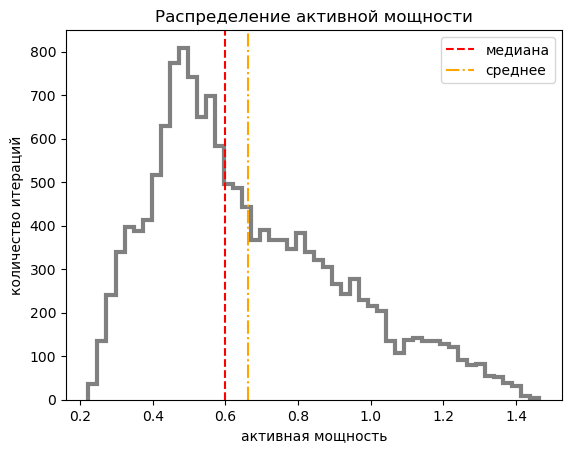

In [27]:
# график распределение активной мощности

data_arc_new['Активная мощность'].hist(bins=50, histtype='step', linewidth=3, grid=False, color='grey')
plt.title('Распределение активной мощности')
plt.xlabel('активная мощность')
plt.ylabel('количество итераций')
plt.axvline(data_arc_new['Активная мощность'].median(), c='red', linestyle='--', label='медиана')
plt.axvline(data_arc_new['Активная мощность'].mean(), c='orange', linestyle='-.', label='среднее')
plt.legend();

- видим смещение вправо

In [28]:
# средняя активная мощность по партиям

data_arc_group = pd.merge(data_arc_group,
         data_arc_new.groupby('key')['Активная мощность'].mean(),
        on='key').rename(columns={'Активная мощность': 'Активная мощность средняя'})

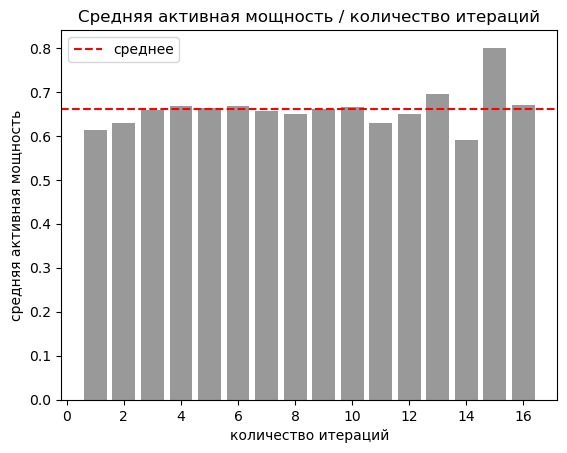

In [29]:
# график средняя активная мощность в зависимости от количества итераций

mean_active_power = data_arc_group.groupby('Количество итераций')['Активная мощность средняя'].mean()

plt.bar(mean_active_power.index, mean_active_power, color='grey', alpha= 0.8)

plt.axhline(data_arc_group['Активная мощность средняя'].mean(), color = 'red', linestyle = '--', label='среднее')

plt.xticks(rotation=0)
plt.title('Средняя активная мощность / количество итераций')
plt.xlabel('количество итераций')
plt.ylabel('средняя активная мощность')
plt.legend();

- не можем отметить связь среднй активной мощности и количества итераций

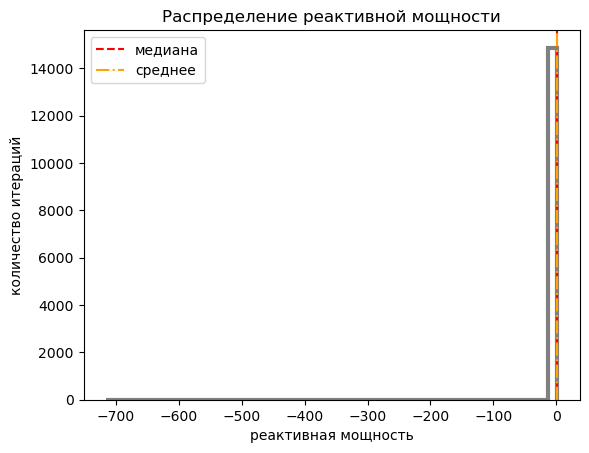

In [30]:
# график распределение реактивной мощности

data_arc_new['Реактивная мощность'].hist(bins=50, histtype='step', linewidth=3, grid=False, color='grey')
plt.title('Распределение реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('количество итераций')
plt.axvline(data_arc_new['Реактивная мощность'].median(), c='red', linestyle='--', label='медиана')
plt.axvline(data_arc_new['Реактивная мощность'].mean(), c='orange', linestyle='-.', label='среднее')
plt.legend();

- можем отметить аномальное значение

In [31]:
data_arc_new[data_arc_new['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева секунд
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,109


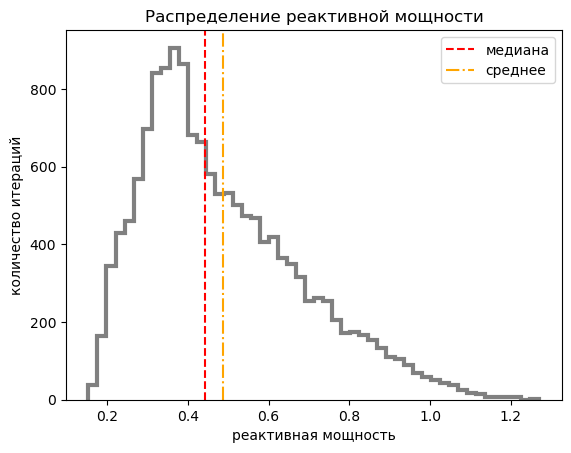

In [32]:
# график распределение реактивной мощности без аномального значения

reac_power_without_outlier = data_arc_new[data_arc_new['Реактивная мощность'] > 0]['Реактивная мощность']

reac_power_without_outlier.hist(bins=50, histtype='step', linewidth=3, grid=False, color='grey')
plt.title('Распределение реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('количество итераций')
plt.axvline(reac_power_without_outlier.median(), c='red', linestyle='--', label='медиана')
plt.axvline(reac_power_without_outlier.mean(), c='orange', linestyle='-.', label='среднее')
plt.legend();

- видим смещение вправо

In [33]:
# средняя реактивная мощность по партиям

data_arc_group = pd.merge(data_arc_group,
         data_arc_new.groupby('key')['Реактивная мощность'].mean(),
        on='key').rename(columns={'Реактивная мощность': 'Реактивная мощность средняя'})

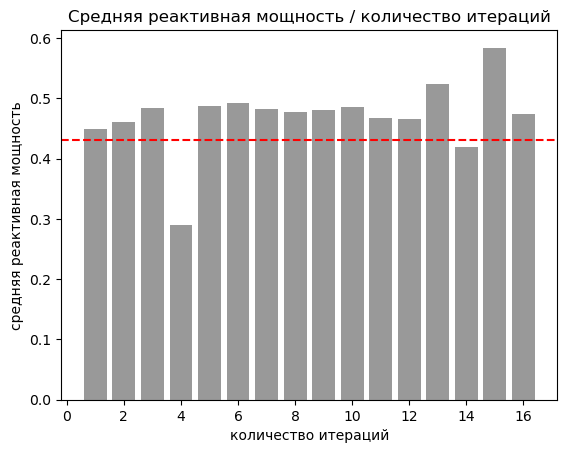

In [34]:
# график средняя реактивная мощность в зависимости от количества итераций

# data_arc_group.groupby('Количество итераций')['Реактивная мощность средняя'].mean().plot(kind='bar')

mean_reactive_power = data_arc_group.groupby('Количество итераций')['Реактивная мощность средняя'].mean()

plt.bar(mean_reactive_power.index, mean_reactive_power, color='grey', alpha= 0.8)

plt.axhline(data_arc_group['Реактивная мощность средняя'].mean(), color = 'red', linestyle = '--', label='среднее')

plt.xticks(rotation=0)
plt.title('Средняя реактивная мощность / количество итераций')
plt.xlabel('количество итераций')
plt.ylabel('средняя реактивная мощность');

- не можем отметить связь среднй реактивной мощности и количества итераций
- провал в 4-й итерации скорее всего связана с аномальным значением

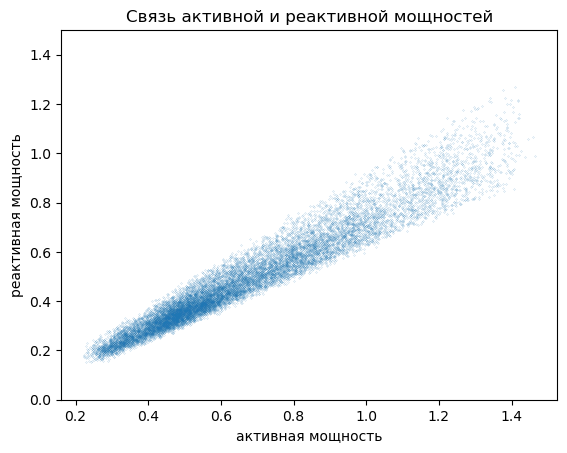

In [35]:
plt.scatter(data_arc_new['Активная мощность'], data_arc_new['Реактивная мощность'], s=0.01)

plt.title('Связь активной и реактивной мощностей')
plt.xlabel('активная мощность')
plt.ylabel('реактивная мощность')
plt.ylim(0, 1.5);

In [36]:
data_arc_new[data_arc_new['Реактивная мощность']>0][['Реактивная мощность', 'Активная мощность']]\
    .corr(method='pearson')

,Реактивная мощность,Активная мощность
Реактивная мощность,1.000000,0.966373
Активная мощность,0.966373,1.000000


- видим сильную линейную связь;
- видим рост дисперсии с увеличением значений.

__Вывод__:
- пропущенных значений не обнаружили;
- дублей не выявили;
- выявили рост общей длительности нагрева с ростом количества итераций;
- зависимость средней активной/реактивной мощности от количества итераций не выявили;
- выявили сильную линейную связь между активной и реактивной мощностями.

## данные о подаче сыпучих материалов (объём)

In [37]:
data_bulk_new.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [38]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [39]:
pd.DataFrame(data_bulk_new.isna().mean(), columns=['is_na'])\
    .sort_values('is_na', ascending=False)\
    .style.background_gradient('coolwarm')

,is_na
Bulk 8,0.999680
Bulk 13,0.994247
Bulk 9,0.993928
Bulk 2,0.992969
Bulk 7,0.992010
Bulk 5,0.975391
Bulk 10,0.943752
Bulk 11,0.943432
Bulk 1,0.919463
Bulk 6,0.815916


- видим большое количество пропусков

In [40]:
# полные дубли

data_bulk_new.duplicated().sum()

0

In [41]:
data_bulk_new['key'].nunique()

3129

- можем говорить об одной итерации использования сыпучих материалов
- видим отсутсвие данных по ряду партий

In [42]:
data_bulk_new.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [43]:
def box_plot(df_, columns, line=1, col=3, figsize = (12, 3)):
    '''
    функция строит boxplo
    на вход передается название датафрейма и список колонок
    '''

    fig, ax = plt.subplots(figsize = figsize)
    
    # счетчик для subplot
    counter = 1

    for column in columns:
        
        # boxplot
        ax = plt.subplot(line, col, counter)
        df_[column].dropna().plot(kind='box', vert=False)
        plt.title(column, size = 10, loc='left', y= 1, x = 0) # заголовок
        plt.yticks([])
        
        counter += 1

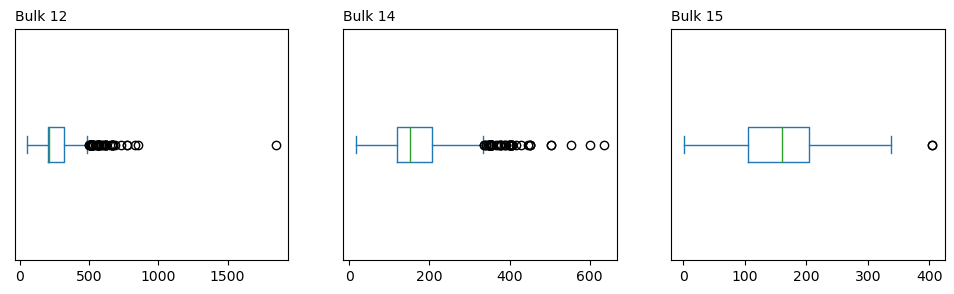

In [44]:
# график признакам с наименьшим количеством пропусков

box_plot(data_bulk_new, ['Bulk 12', 'Bulk 14', 'Bulk 15'])

- видим аномальные значения

## данные о подаче сыпучих материалов (время)

In [45]:
data_bulk_time_new.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


In [46]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


__Вывод:__
- видим большое количество пропущенных значений, что говорит о частоте исполльзования тех или иных сыпучих материалов;
- можем говорить об одной итерации использования сыпучих материалов;
- видим отсутсвие данных по ряду партий.

## данные о продувке сплава газом

In [47]:
data_gas_new.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [48]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [49]:
data_gas_new['Газ 1'].nunique()

3239

In [50]:
print(f' количество партий в данных по электродам: {num_of_parties}')

 количество партий в данных по электродам: 3214


In [51]:
print(f"совпали номера партий: {data_gas_new[data_gas_new['key'].isin(data_bulk_new['key'].unique())].shape[0]}")

совпали номера партий: 3127


In [52]:
print(f"не совпали номера партий: {data_gas_new[~data_gas_new['key'].isin(data_bulk_new['key'].unique())].shape[0]}")

не совпали номера партий: 112


- видим несовпадение по номерам партий

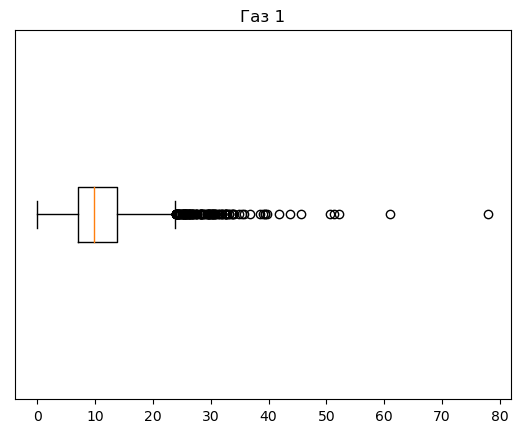

In [53]:
plt.boxplot(data_gas_new['Газ 1'], vert=False)
plt.title('Газ 1')
plt.yticks([]);

- видим выбросы

__Вывод:__
- видим несовпадения по номерам партий;
- отсутсвует время продувки.

## результаты измерения температуры

In [54]:
data_temp_new.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


In [55]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


- видим пропуске в данных о температуре

In [56]:
data_temp_new['key'].nunique()

3216

- видим несовпадения по партиям

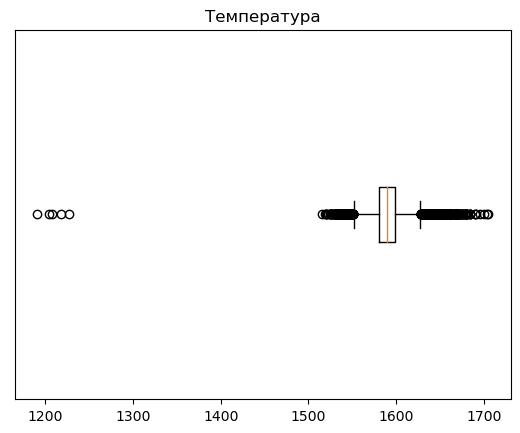

In [57]:
plt.boxplot(data_temp_new['Температура'].dropna(), vert=False)
plt.title('Температура')
plt.yticks([]);

- видим выбросы значений температуры как в одну так и вдругую стороны

__Выводы:__
- несоответсвие партиям;
- выбросы значений температуры.

## данные о проволочных материалах (объём)

In [58]:
data_wire_new.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
pd.DataFrame(data_wire_new.isna().mean(), columns=['is_na'])\
    .sort_values('is_na', ascending=False)\
    .style.background_gradient('coolwarm')

,is_na
Wire 5,0.999675
Wire 7,0.996430
Wire 4,0.995456
Wire 8,0.993833
Wire 9,0.990587
Wire 3,0.979552
Wire 6,0.976306
Wire 2,0.649789
Wire 1,0.008439
key,0.000000


- видим большое количество пропусков

In [60]:
# дубли

data_wire_new.duplicated().sum()

0

In [61]:
data_wire_new['key'].nunique()

3081

- видим несоответсвие по числу партий

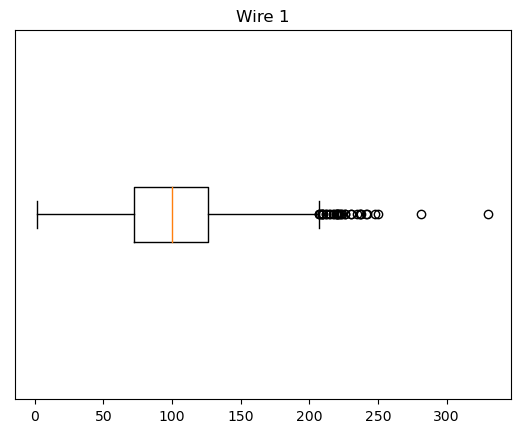

In [62]:
plt.boxplot(data_wire_new['Wire 1'].dropna(), vert=False)
plt.title('Wire 1')
plt.yticks([]);

- на данных с наименьшим количеством пропусков видим выбросы.

## данные о проволочных материалах (время)

In [63]:
data_wire_time_new.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


- видим указание времени без уточнения время начала или окончания

__Выводы:__
- большое количество пропущенных значений, что может говорить о частоте используемых материалов;
- несовпадение по числу партий.

## Процесс

Нанесем на график временные метки различных этапов процесса

### Процесс с одной итерацией

In [65]:
# найдем процесс с одной итерацией

data_arc_group[data_arc_group['Количество итераций'] == 1].head(1)

,Количество итераций,Длительность нагрева общая секунд,Активная мощность средняя,Реактивная мощность средняя
key,,,,
49,1,126,0.994742,0.706443


In [66]:
data_arc_new_49 = data_arc_new[data_arc_new['key']==49]
data_arc_new_49

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева секунд
233,49,2019-05-05 09:51:22,2019-05-05 09:53:28,0.994742,0.706443,126


In [67]:
# для построения графика сформируем временную таблицу начала и окончания нагрева

tmp = data_arc_new_49[['Начало нагрева дугой', 'Конец нагрева дугой']].T
tmp['batch'] = 49
tmp

,233,batch
Начало нагрева дугой,2019-05-05 09:51:22,49
Конец нагрева дугой,2019-05-05 09:53:28,49


In [68]:
# временная таблица замера температуры

data_temp_new_49 = data_temp_new[data_temp_new['key']==49]
data_temp_new_49

,key,Время замера,Температура
279,49,2019-05-05 09:51:12,1626.0
280,49,2019-05-05 10:50:46,1588.0


In [69]:
# временная таблица подачи сыпучих материалов

data_bulk_time_new_49 = data_bulk_time_new[data_bulk_time_new['key'] == 49]
data_bulk_time_new_49

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
46,49,NaN,NaN,NaN,NaN,NaN,2019-05-05 09:53:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
data_bulk_time_new_49 = data_bulk_time_new_49[['key', 'Bulk 6']]
data_bulk_time_new_49

,key,Bulk 6
46,49,2019-05-05 09:53:40


In [71]:
# временная таблица подачи проволочных материалов

data_wire_time_new_49 = data_wire_time_new[data_wire_time_new['key'] == 49]
data_wire_time_new_49

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
46,49,2019-05-05 09:53:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
data_wire_time_new_49 = data_wire_time_new_49[['key', 'Wire 1']]
data_wire_time_new_49

,key,Wire 1
46,49,2019-05-05 09:53:40


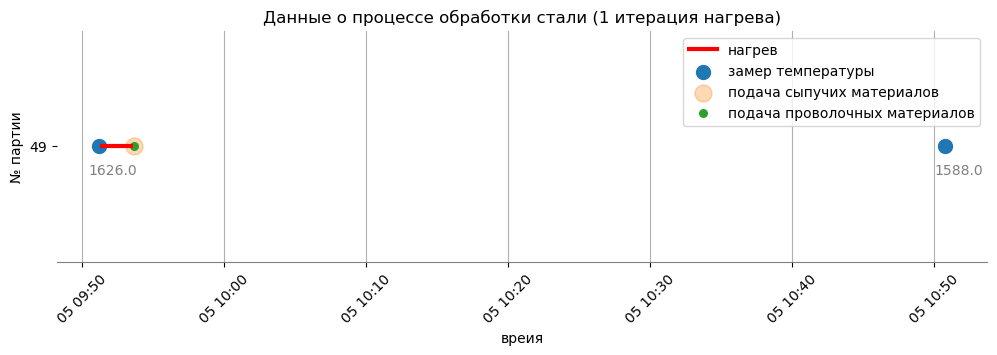

In [73]:
# график с временными метками этапов процесса

fig, ax = plt.subplots(figsize=(12, 3))

# нагрев
plt.plot(tmp[tmp.columns[0]], tmp['batch'], label='нагрев', linewidth=3, color='red')

# замер температуы
plt.scatter(data_temp_new_49['Время замера'], data_temp_new_49['key'],
            label='замер температуры', s=100)

# значение температуры
for _, t in data_temp_new_49.iterrows():
    plt.annotate(t['Температура'], # текст
        (pd.Timestamp(t['Время замера']), t['key']), # координаты 
        textcoords="offset points", # расположение текста
        xytext=(10, -20), # расстояние от координат (x,y)
        ha='center', size=10, color='grey')

# подача сыпучих материалов
plt.scatter(data_bulk_time_new_49['Bulk 6'], data_bulk_time_new_49['key'],
            label='подача сыпучих материалов', s=150, alpha=.3)

# подача проволочных материалов
plt.scatter(data_wire_time_new_49['Wire 1'], data_bulk_time_new_49['key'],  
            label='подача проволочных материалов', s=30)

plt.title('Данные о процессе обработки стали (1 итерация нагрева)')
plt.xlabel('вреия')
plt.ylabel('№ партии')

plt.xticks(rotation=45)
plt.yticks([49])
plt.grid(axis='x')
plt.legend()

# настройка видимости рамок
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey');

- первый замер температуры происходит до начала нагрева
- подача сыпучих и проволочных материалова происходит одномоментно
- повторный замер температуры происходит практически через час

### Процесс с шестью итерациями

In [74]:
# найдем процесс с шестью итерациями

data_arc_group[data_arc_group['Количество итераций'] == 6].head(1)

,Количество итераций,Длительность нагрева общая секунд,Активная мощность средняя,Реактивная мощность средняя
key,,,,
10,6,825,0.519796,0.359157


In [75]:
# для построения графика сформируем временную таблицу начала и окончания нагрева

data_arc_new_10 = data_arc_new[data_arc_new['key'] == 10]
data_arc_new_10

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева секунд
39,10,2019-05-03 16:14:09,2019-05-03 16:16:36,0.423798,0.296542,147
40,10,2019-05-03 16:17:59,2019-05-03 16:22:16,0.627009,0.432609,257
41,10,2019-05-03 16:24:39,2019-05-03 16:26:49,0.467115,0.313622,130
42,10,2019-05-03 16:28:06,2019-05-03 16:29:41,0.522005,0.361521,95
43,10,2019-05-03 16:32:25,2019-05-03 16:34:09,0.502584,0.340440,104
44,10,2019-05-03 16:36:19,2019-05-03 16:37:51,0.576267,0.410207,92


In [76]:
# временная таблица замера температуры

data_temp_new_10 = data_temp_new[data_temp_new['key']==10]
data_temp_new_10

,key,Время замера,Температура
48,10,2019-05-03 16:13:59,1574.0
49,10,2019-05-03 16:17:49,1580.0
50,10,2019-05-03 16:24:29,1585.0
51,10,2019-05-03 16:27:56,1586.0
52,10,2019-05-03 16:32:15,1586.0
53,10,2019-05-03 16:36:09,1586.0
54,10,2019-05-03 16:39:50,1593.0


In [77]:
# временная таблица подачи сыпучих материалов

data_bulk_time_new_10 = data_bulk_time_new[data_bulk_time_new['key'] == 10]
data_bulk_time_new_10

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [78]:
bulk_columns = ['Bulk 12', 'Bulk 14', 'Bulk 15']

data_bulk_time_new_10 = data_bulk_time_new_10[['key', *bulk_columns]]
data_bulk_time_new_10

,key,Bulk 12,Bulk 14,Bulk 15
9,10,2019-05-03 16:38:11,2019-05-03 16:34:24,2019-05-03 16:29:56


In [79]:
# временная таблица подачи проволочных материалов

data_wire_time_new_10 = data_wire_time_new[data_wire_time_new['key'] == 10]
data_wire_time_new_10

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
wire_columns = ['Wire 1', 'Wire 2']

data_wire_time_new_10 = data_wire_time_new_10[['key', *wire_columns]]
data_wire_time_new_10

,key,Wire 1,Wire 2
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36


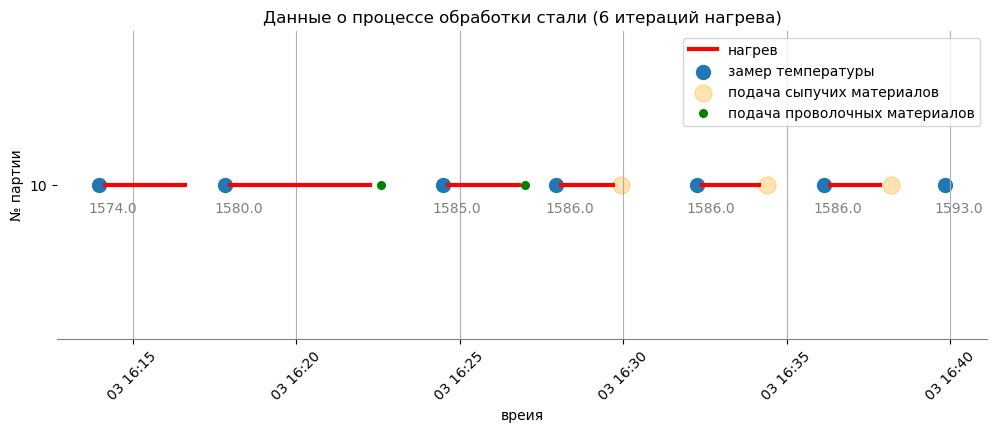

In [81]:
fig, ax = plt.subplots(figsize=(12, 4))

for i in range(data_arc_new_10.shape[0]):    
    tmp_10 = pd.DataFrame(data_arc_new_10.iloc[i][['Начало нагрева дугой', 'Конец нагрева дугой']])
    tmp_10['batch'] = 10
    if i == 0:
        label='нагрев'
    else:
        label=''
    plt.plot(tmp_10[tmp_10.columns[0]], tmp_10['batch'], label=label, linewidth=3, color='red')
    
plt.scatter(data_temp_new_10['Время замера'], data_temp_new_10['key'],
            label='замер температуры', s=100)

# значение температуры
for _, t in data_temp_new_10.iterrows():
    plt.annotate(t['Температура'], # текст
        (pd.Timestamp(t['Время замера']), t['key']), # координаты 
        textcoords="offset points", # расположение текста
        xytext=(10, -20), # расстояние от координат (x,y)
        ha='center', size=10, color='grey')

counter_bulk = 0
for b in bulk_columns:
    if counter_bulk == 0:
        label='подача сыпучих материалов'
    else:
        label=''
    counter_bulk += 1
    plt.scatter(data_bulk_time_new_10[b], data_bulk_time_new_10['key'],
            label=label, s=150, alpha=.3, color='orange')

counter_wire = 0
for w in wire_columns:
    if counter_wire == 0:
        label='подача проволочных материалов'
    else:
        label=''
    counter_wire += 1
    plt.scatter(data_wire_time_new_10[w], data_wire_time_new_10['key'],
            label=label, s=30, color='green')
    
plt.title('Данные о процессе обработки стали (6 итераций нагрева)')
plt.xlabel('вреия')
plt.ylabel('№ партии')

plt.xticks(rotation=45)
plt.yticks([10])
plt.grid(axis='x')
plt.legend()
# настройка видимости рамок
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey');

- первый замер температуры происходит до начала нагрева
- временная задержка между окончанием нагрева и замером температуры
- подача сыпучих и проволочных материалов происходит в разные моменты времени

## Итог

__данные об электродах__:
- пропущенных значений не обнаружили;
- дублей не выявили;
- выявили рост общей длительности нагрева с ростом количества итераций;
- зависимость средней активной/реактивной мощности от количества итераций не выявили;
- выявили сильную линейную связь между активной и реактивной мощностями.

__данные о подаче сыпучих материалов:__
- видим большое количество пропущенных значений, что говорит о частоте исполльзования тех или иных сыпучих материалов;
- можем говорить об одной итерации использования сыпучих материалов;
- видим отсутсвие данных по ряду партий.

__данные о продувке сплава газом:__
- видим несовпадения по номерам партий;
- отсутсвует время продувки.

__результаты измерения температуры:__
- несоответсвие партиям;
- выбросы значений температуры.

__данные о проволочных материалах:__
- большое количество пропущенных значений, что может говорить о частоте используемых материалов:
- несовпадение по числу партий;

# Подготовка данных / конструирование признаков

## целевой признак

In [82]:
# целевым признаком является последний замер температуры соответсвующей партии

df_output_temperature = pd.merge(data_temp_new.groupby('key', as_index=False)['Время замера'].max(), data_temp_new,
    on=['key', 'Время замера'], how='left').dropna()

In [83]:
df_output_temperature = df_output_temperature.rename(columns={'Время замера': 'Время последнего замера',
                                                              'Температура': 'Итоговая температура'})

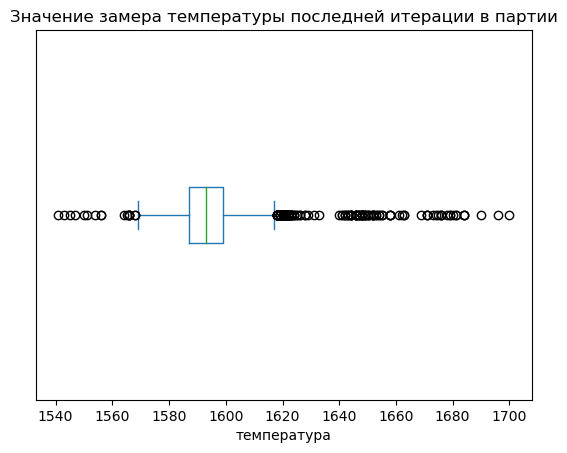

In [84]:
# график разброса значений итоговой температуры

df_output_temperature['Итоговая температура'].plot(kind='box', vert=False)
    
plt.title('Значение замера температуры последней итерации в партии')
plt.xlabel('температура')
plt.yticks([]);

- видим разброс значений температуры

In [85]:
df_output_temperature

,key,Время последнего замера,Итоговая температура
0,1,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:36:39,1602.0
...,...,...,...
2472,2495,2019-08-10 11:50:47,1591.0
2473,2496,2019-08-10 12:25:13,1591.0
2474,2497,2019-08-10 12:53:28,1589.0
2475,2498,2019-08-10 13:23:31,1594.0


## входная температура

In [86]:
# входная температура

df_input_temperature = pd.merge(data_temp_new.groupby('key', as_index=False)['Время замера'].min(), data_temp_new,
    on=['key', 'Время замера'], how='left').dropna()

In [87]:
df_input_temperature = df_input_temperature.rename(columns={'Время замера': 'Время первого замера',
                                          'Температура': 'Входная температура'})

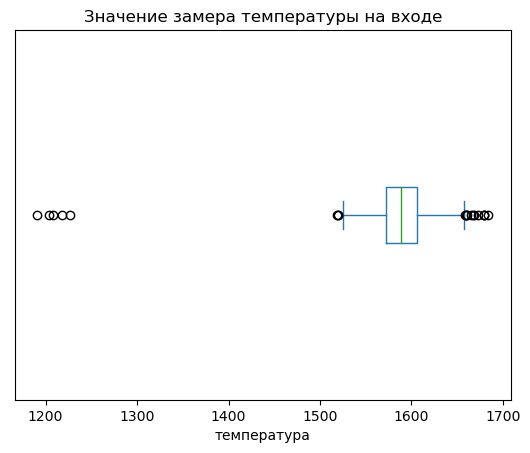

In [88]:
# график разброса значений входной температуры

df_input_temperature['Входная температура'].plot(kind='box', vert=False)
    
plt.title('Значение замера температуры на входе')
plt.xlabel('температура')
plt.yticks([]);

- видим аномальные значения около 1200 градусов. Сделаем допущение, что попали данные относящиеся к другой марке стали. Ввиду крайне малого объема, удалим.

In [89]:
df_input_temperature = df_input_temperature[df_input_temperature['Входная температура'] > 1400]

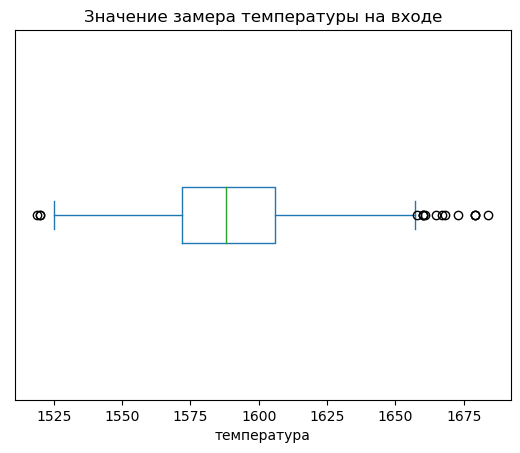

In [90]:
# график разброса значений входной температуры

df_input_temperature['Входная температура'].plot(kind='box', vert=False)
    
plt.title('Значение замера температуры на входе')
plt.xlabel('температура')
plt.yticks([]);

In [91]:
# Объединим данные входной и итоговой температур в один датасет

df = pd.merge(df_output_temperature, df_input_temperature, on = 'key', how='inner')

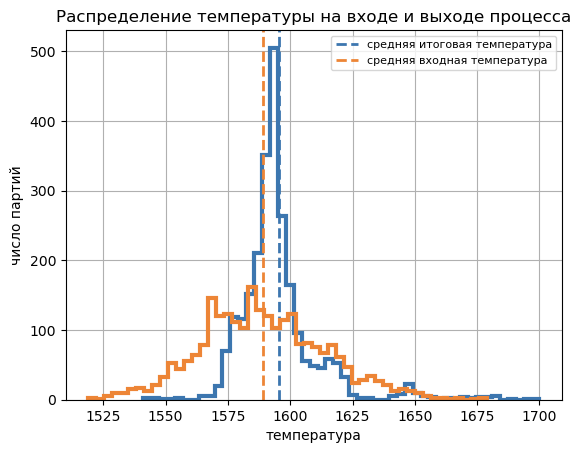

In [92]:
# распределение входящих и итоговых температур

# цвет вертикальной линии
output_color = '#3c76af'

# график распредаления итоговой температуры
df['Итоговая температура'].hist(bins=50, histtype='step', linewidth=3, color=output_color)

# среднее значение итоговой температуры
plt.axvline(df['Итоговая температура'].mean(),
    color=output_color, label='средняя итоговая температура', linewidth=2, linestyle='--')

# цвет вертикальной линии
input_color = '#ed8536'

# график распредаления входящей температуры
df['Входная температура'].hist(bins=50, histtype='step', linewidth=3, color=input_color)

# среднее значение температуры на входе
plt.axvline(df['Входная температура'].mean(),
    color=input_color, label='средняя входная температура', linewidth=2, linestyle='--', );

plt.title('Распределение температуры на входе и выходе процесса')
plt.xlabel('температура')
plt.ylabel('число партий')
plt.legend(fontsize=8);

- видим близкие средние значения;
- дисперсия температуры на входе больше чем на выходе процесса

In [93]:
df

,key,Время последнего замера,Итоговая температура,Время первого замера,Входная температура
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...,...
2468,2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:27:47,1570.0
2469,2496,2019-08-10 12:25:13,1591.0,2019-08-10 11:56:48,1554.0
2470,2497,2019-08-10 12:53:28,1589.0,2019-08-10 12:37:26,1571.0
2471,2498,2019-08-10 13:23:31,1594.0,2019-08-10 12:58:11,1591.0


## длительность нагрева

In [94]:
# общее время нагрева соответсвующей партии

df_heating_time = data_arc_new.groupby('key', as_index=False)['Длительность нагрева секунд'].sum()

In [95]:
df = pd.merge(df, df_heating_time, on = 'key', how='inner')

In [96]:
df

,key,Время последнего замера,Итоговая температура,Время первого замера,Входная температура,Длительность нагрева секунд
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,1098
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,811
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,655
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,741
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,869
...,...,...,...,...,...,...
2466,2495,2019-08-10 11:50:47,1591.0,2019-08-10 11:27:47,1570.0,723
2467,2496,2019-08-10 12:25:13,1591.0,2019-08-10 11:56:48,1554.0,940
2468,2497,2019-08-10 12:53:28,1589.0,2019-08-10 12:37:26,1571.0,569
2469,2498,2019-08-10 13:23:31,1594.0,2019-08-10 12:58:11,1591.0,750


## время без нагрева

In [97]:
# общее время без нагрева соответсвующей партии

df['Длительность без нагрева секунд'] = (
                                         (
                                          pd.to_datetime(df['Время последнего замера']) -
                                          pd.to_datetime(df['Время первого замера'])
                                         ).dt.seconds -
                                          df['Длительность нагрева секунд']
                                        )

In [98]:
# удалим временные метки замеров температур

df = df.drop(['Время последнего замера', 'Время первого замера'], axis=1)

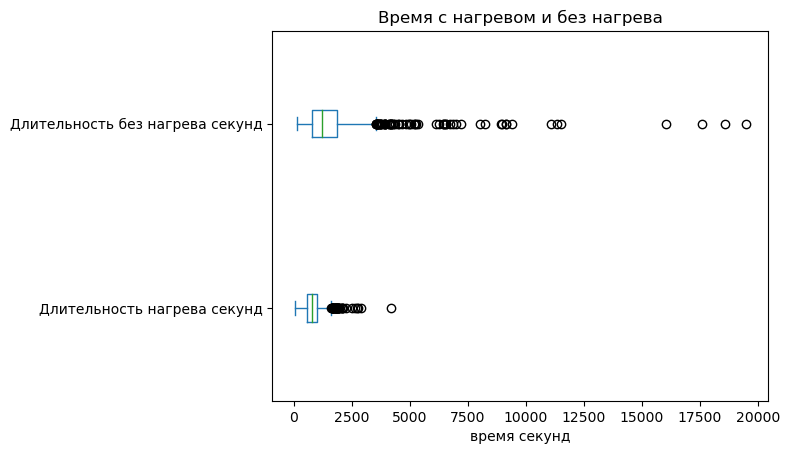

In [99]:
# разброс значений времени нагрева и без нагрева

# график
df[['Длительность нагрева секунд', 'Длительность без нагрева секунд']].plot(kind='box', vert=False)

plt.title('Время с нагревом и без нагрева')
plt.xlabel('время секунд');

- длительность без нагрева имеет больше выбросов

In [100]:
df

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд
0,1,1613.0,1571.0,1098,616
1,2,1602.0,1581.0,811,454
2,3,1599.0,1596.0,655,1098
3,4,1625.0,1601.0,741,479
4,5,1602.0,1576.0,869,667
...,...,...,...,...,...
2466,2495,1591.0,1570.0,723,657
2467,2496,1591.0,1554.0,940,765
2468,2497,1589.0,1571.0,569,393
2469,2498,1594.0,1591.0,750,770


## средняя мощность

In [101]:
# среднюю мощность(активной, реактивной) посчитаем как средневзвешенное соответсвующей мощности

def average_power(power):
    '''
    функция считает средневзвешенное значение мощности (активной, реактивной)
    '''
    tmp_df = data_arc_new.copy()
    
    # мощность с учетом длительности нагрева
    tmp_df['Мощн_ДлитНагревСек'] = tmp_df[power] *\
                                         tmp_df['Длительность нагрева секунд']
    
    # агрегируем по партиям (активная мощность)
    df_average_power = tmp_df.groupby('key', as_index=False)\
        .agg({'Мощн_ДлитНагревСек':sum, 'Длительность нагрева секунд':sum})
    
    # средневзвешенное активной мощности
    df_average_power['Cредневзвешенное ' + power] = (
        df_average_power['Мощн_ДлитНагревСек']/df_average_power['Длительность нагрева секунд']
                                                             )
    # удалим лишние признаки
    df_average_power = df_average_power.drop(['Мощн_ДлитНагревСек', 'Длительность нагрева секунд'], axis=1)
    
    return df_average_power

In [102]:
average_active_power = average_power('Активная мощность')
average_active_power.head(3)

,key,Cредневзвешенное Активная мощность
0,1,0.572511
1,2,0.487400
2,3,0.888206


In [103]:
average_reactive_power = average_power('Реактивная мощность')
average_reactive_power.head(3)

,key,Cредневзвешенное Реактивная мощность
0,1,0.404817
1,2,0.338705
2,3,0.653495


In [104]:
# добавим в датафрейм

# Активная мощность
df = pd.merge(df, average_active_power, on='key', how='inner')

In [105]:
# Реактивная мощность

df = pd.merge(df, average_reactive_power, on='key', how='inner')

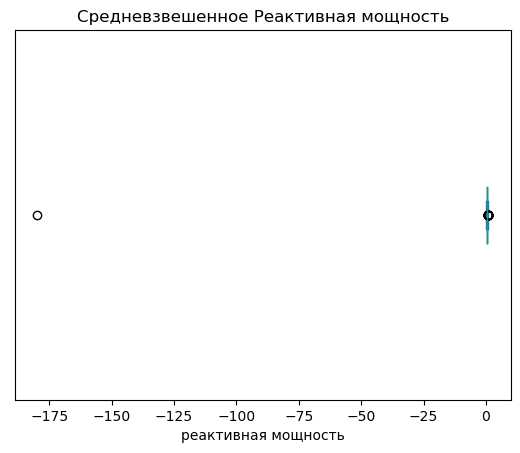

In [106]:
# в признаке реактивная мощность ранее был выявлен выброс

df['Cредневзвешенное Реактивная мощность'].plot(kind='box', vert=False)
plt.title('Cредневзвешенное Реактивная мощность')
plt.xlabel('реактивная мощность')
plt.yticks([]);

In [107]:
# удалим партию в которой наблюдается выброс реактивной мощности

df = df[df['Cредневзвешенное Реактивная мощность'] > 0]

In [108]:
df

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд,Cредневзвешенное Активная мощность,Cредневзвешенное Реактивная мощность
0,1,1613.0,1571.0,1098,616,0.572511,0.404817
1,2,1602.0,1581.0,811,454,0.487400,0.338705
2,3,1599.0,1596.0,655,1098,0.888206,0.653495
3,4,1625.0,1601.0,741,479,0.733752,0.558626
4,5,1602.0,1576.0,869,667,0.474316,0.348758
...,...,...,...,...,...,...,...
2466,2495,1591.0,1570.0,723,657,0.790511,0.542574
2467,2496,1591.0,1554.0,940,765,0.718322,0.486157
2468,2497,1589.0,1571.0,569,393,1.195653,0.813467
2469,2498,1594.0,1591.0,750,770,0.633225,0.447382


## сыпучие материалы

In [109]:
# Сделаем предположение, что сыпучие материалы служат для изменения химического состава стали
# т.к. отсутсвуют данные о теплопроводности, сделаем допущение, что различиями можно пренебречь
# объединим все признаки связанные с сыпучими материалами в один

In [110]:
def total_material(df_f, material_name):
    '''
    функция суммирует столбцы с материалами
    на вход передается датафрейм и название материала
    '''
    tmp_df = df_f.copy()
    
    # список столбцов
    tmp_df_columns = list(tmp_df.columns)
    
    # удалим признак партии
    tmp_df_columns.remove('key')
    
    # заполним пропуски нулями
    tmp_df[tmp_df_columns] = tmp_df[tmp_df_columns].fillna(0)
    
    # создадим столбец с суммарным значением    
    tmp_df[material_name] = 0
    
    # проссумируем значения в столбцах
    for column in tmp_df_columns:
        tmp_df[material_name] += tmp_df[column]
        
    return tmp_df[['key', material_name]]

In [111]:
bulk_materials = total_material(data_bulk_new, 'Сыпучие материалы')

In [112]:
# добавим полученные данные в датафрейм

df = pd.merge(df, bulk_materials, on='key', how='inner')

In [113]:
df

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд,Cредневзвешенное Активная мощность,Cредневзвешенное Реактивная мощность,Сыпучие материалы
0,1,1613.0,1571.0,1098,616,0.572511,0.404817,553.0
1,2,1602.0,1581.0,811,454,0.487400,0.338705,582.0
2,3,1599.0,1596.0,655,1098,0.888206,0.653495,544.0
3,4,1625.0,1601.0,741,479,0.733752,0.558626,595.0
4,5,1602.0,1576.0,869,667,0.474316,0.348758,584.0
...,...,...,...,...,...,...,...,...
2397,2495,1591.0,1570.0,723,657,0.790511,0.542574,719.0
2398,2496,1591.0,1554.0,940,765,0.718322,0.486157,796.0
2399,2497,1589.0,1571.0,569,393,1.195653,0.813467,665.0
2400,2498,1594.0,1591.0,750,770,0.633225,0.447382,733.0


## проволчные материалы

In [114]:
# аналогично сыпучим обработаем проволчные материалы

In [115]:
wire_materials = total_material(data_wire_new, 'Проволчные материалы')

In [116]:
df = pd.merge(df, wire_materials, on='key', how='inner')

## продувка сплава газом

In [117]:
df = pd.merge(df, data_gas_new, on='key', how='inner')

In [118]:
df

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд,Cредневзвешенное Активная мощность,Cредневзвешенное Реактивная мощность,Сыпучие материалы,Проволчные материалы,Газ 1
0,1,1613.0,1571.0,1098,616,0.572511,0.404817,553.0,60.059998,29.749986
1,2,1602.0,1581.0,811,454,0.487400,0.338705,582.0,96.052315,12.555561
2,3,1599.0,1596.0,655,1098,0.888206,0.653495,544.0,91.160157,28.554793
3,4,1625.0,1601.0,741,479,0.733752,0.558626,595.0,89.063515,18.841219
4,5,1602.0,1576.0,869,667,0.474316,0.348758,584.0,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...,...
2319,2495,1591.0,1570.0,723,657,0.790511,0.542574,719.0,89.150879,7.125735
2320,2496,1591.0,1554.0,940,765,0.718322,0.486157,796.0,114.179527,9.412616
2321,2497,1589.0,1571.0,569,393,1.195653,0.813467,665.0,103.134723,6.271699
2322,2498,1594.0,1591.0,750,770,0.633225,0.447382,733.0,118.110717,14.953657


## корреляция признаков

In [119]:
# итоговый датасет

df.head()

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд,Cредневзвешенное Активная мощность,Cредневзвешенное Реактивная мощность,Сыпучие материалы,Проволчные материалы,Газ 1
0,1,1613.0,1571.0,1098,616,0.572511,0.404817,553.0,60.059998,29.749986
1,2,1602.0,1581.0,811,454,0.487400,0.338705,582.0,96.052315,12.555561
2,3,1599.0,1596.0,655,1098,0.888206,0.653495,544.0,91.160157,28.554793
3,4,1625.0,1601.0,741,479,0.733752,0.558626,595.0,89.063515,18.841219
4,5,1602.0,1576.0,869,667,0.474316,0.348758,584.0,98.352796,5.413692


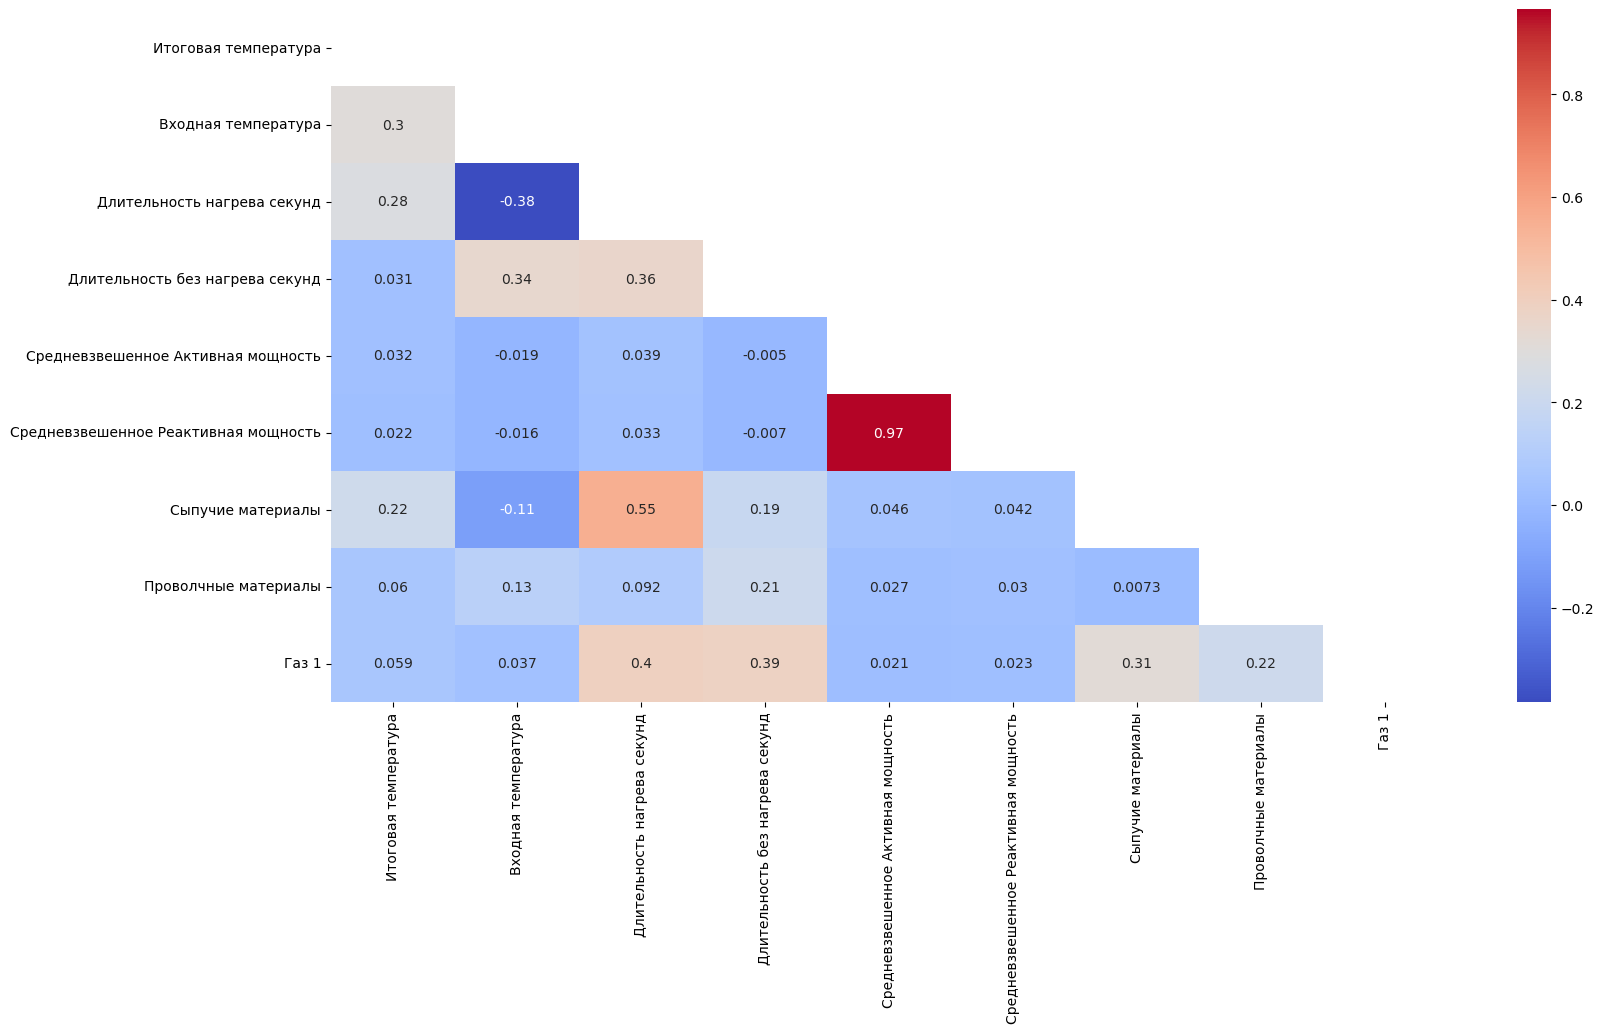

In [120]:
plt.figure(figsize = (18, 9))

matrix = np.triu(df.drop('key', axis=1).corr())
sns.heatmap(df.drop('key', axis=1).corr(), annot = True, fmt='.2g', cmap= 'coolwarm', mask=matrix);

- видим близкую к 1 корреляцию между Активной и Реактивной мощностями. Оставим один признак - Активная мощность

In [121]:
df = df.drop('Cредневзвешенное Реактивная мощность', axis=1)

In [122]:
# поверка на пропуски

df.isna().sum()

key                                   0
Итоговая температура                  0
Входная температура                   0
Длительность нагрева секунд           0
Длительность без нагрева секунд       0
Cредневзвешенное Активная мощность    0
Сыпучие материалы                     0
Проволчные материалы                  0
Газ 1                                 0
dtype: int64

In [123]:
# размер

df.shape

(2324, 9)

In [124]:
df

,key,Итоговая температура,Входная температура,Длительность нагрева секунд,Длительность без нагрева секунд,Cредневзвешенное Активная мощность,Сыпучие материалы,Проволчные материалы,Газ 1
0,1,1613.0,1571.0,1098,616,0.572511,553.0,60.059998,29.749986
1,2,1602.0,1581.0,811,454,0.487400,582.0,96.052315,12.555561
2,3,1599.0,1596.0,655,1098,0.888206,544.0,91.160157,28.554793
3,4,1625.0,1601.0,741,479,0.733752,595.0,89.063515,18.841219
4,5,1602.0,1576.0,869,667,0.474316,584.0,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...
2319,2495,1591.0,1570.0,723,657,0.790511,719.0,89.150879,7.125735
2320,2496,1591.0,1554.0,940,765,0.718322,796.0,114.179527,9.412616
2321,2497,1589.0,1571.0,569,393,1.195653,665.0,103.134723,6.271699
2322,2498,1594.0,1591.0,750,770,0.633225,733.0,118.110717,14.953657


# Разбиение на обучающую, тестовую выборки

In [125]:
X = df.drop(['key', 'Итоговая температура'], axis=1)
y = df['Итоговая температура']

In [126]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Подготовка базовой модели

In [127]:
base_model = DummyRegressor(strategy='median')

In [128]:
# метрика для оценки модели

my_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [129]:
# обучение с применением кросс-валидации

cv_base_model = cross_val_score(base_model, X_train, y_train, cv=5, scoring=my_scorer)

In [130]:
# среднее значение метрики

cv_base_model.mean().round(2)*(-1)

8.0

Модель не проходит порог

# Обучение моделей

## Линейная регрессия

In [131]:
# pipeline

lr_pipe = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

In [132]:
# обучение с применением кросс-валидации

cv_lr = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring=my_scorer)

In [133]:
# среднее значение метрики

cv_lr.mean().round(2)*(-1)

6.4

Значение выше порогового

In [134]:
# обучим модель на всей учебной выборке

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [135]:
# визуализация важности признаков

def feature_importance_func(model_coef = lr_pipe[1].coef_):
    '''
    функция визуализирует важность параметров для модели
    '''

    feature_importance = {}

    for feature, importance in zip(X.columns, model_coef):
        feature_importance[feature] = importance
        
    importances = pd.DataFrame.from_dict(feature_importance, orient='index').rename(columns={0: 'Важность'})
    importances = importances.sort_values(by='Важность')
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Признак'})
    
    fig, ax = plt.subplots(figsize = (12, 8))
    
    plt.barh(importances['Признак'], importances['Важность'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    plt.title('Важность признаков', size = 24, loc='left', y= 1.05)
    plt.ylabel('Признак', color='grey')
    plt.xlabel('Важность', color='grey')
        

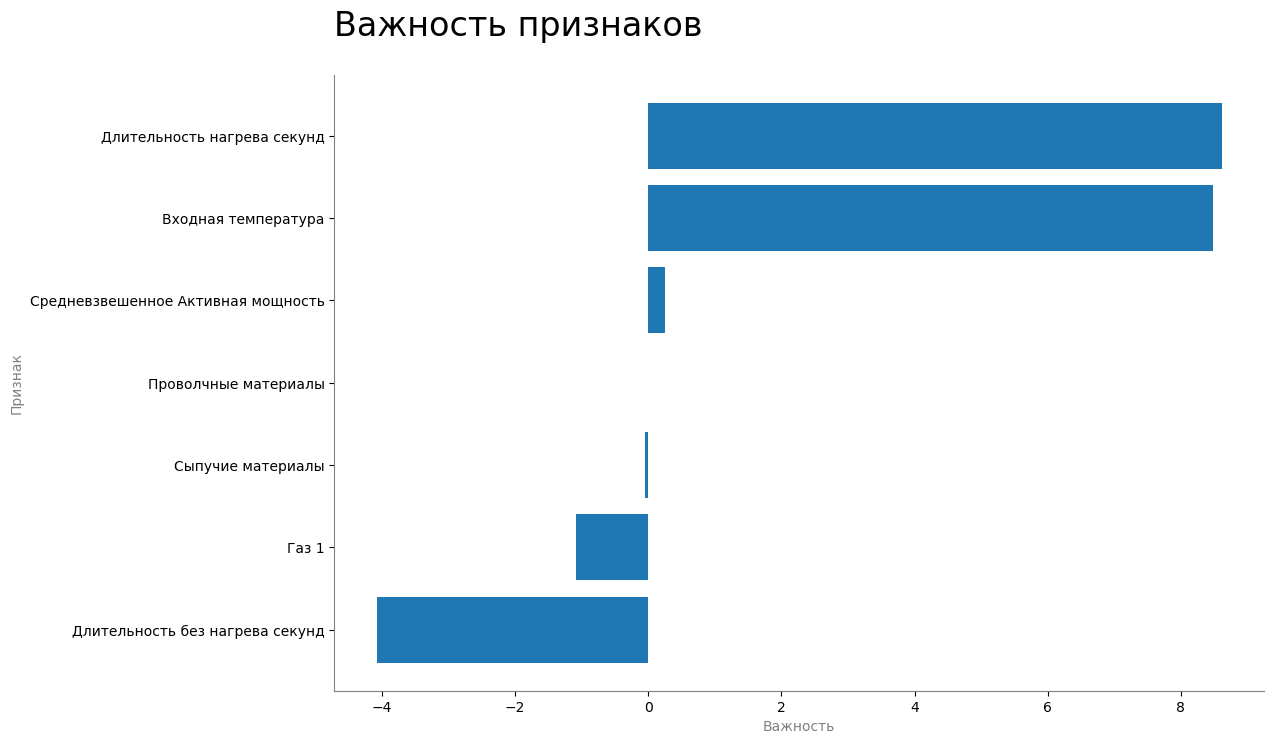

In [136]:
# визуализация

feature_importance_func(model_coef = lr_pipe[1].coef_)

Как видим наибольшее значение имеют признаки:
- длительность нагрева;
- входная температура;
- длительность без нагрева.

## К-ближайших соседей

In [137]:
knn_params = { 'n_neighbors' : np.arange(22, 31, 2),
               'leaf_size' : np.arange(2, 7, 2),
             }

In [138]:
knn_model = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_params,
                                 scoring=my_scorer,
                                 cv=5,
                                 n_jobs=-1,
                                 refit=True)

In [139]:
knn_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': array([2, 4, 6]),
                         'n_neighbors': array([22, 24, 26, 28, 30])},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [140]:
knn_model.best_estimator_

KNeighborsRegressor(leaf_size=2, n_neighbors=26)

In [141]:
knn_model.best_score_.round(2)*(-1)

7.74

Модель не проходит порог

KNN не возвращает важность признаков

## Градиентный бустинг

In [142]:
train_pool = Pool(data=X_train, label=y_train)

/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


In [143]:
cat = CatBoostRegressor(random_state=RANDOM_SEED)

In [144]:
cat_grid = {'iterations' : [500],
            'verbose': [100],
            'early_stopping_rounds':[100],
            'learning_rate': [0.05],
            'depth': np.arange(2, 11, 2),
       }

In [145]:
cat_grid_search = GridSearchCV(estimator=cat, param_grid=cat_grid, cv=5, scoring=my_scorer)

In [146]:
cat_grid_search.fit(X_train, y_train)

0:	learn: 10.9803781	total: 54ms	remaining: 26.9s
100:	learn: 8.7256752	total: 79.5ms	remaining: 314ms
200:	learn: 8.0072732	total: 104ms	remaining: 154ms
300:	learn: 7.5682140	total: 134ms	remaining: 88.3ms
400:	learn: 7.2679277	total: 161ms	remaining: 39.6ms
499:	learn: 7.0610375	total: 185ms	remaining: 0us
0:	learn: 11.0649682	total: 279us	remaining: 140ms
100:	learn: 8.7150557	total: 22.5ms	remaining: 89.1ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


200:	learn: 8.0294149	total: 46.5ms	remaining: 69.2ms
300:	learn: 7.6077292	total: 73.7ms	remaining: 48.7ms
400:	learn: 7.3160422	total: 97.1ms	remaining: 24ms
499:	learn: 7.1035556	total: 120ms	remaining: 0us
0:	learn: 10.9295201	total: 293us	remaining: 146ms
100:	learn: 8.6702784	total: 23ms	remaining: 90.8ms
200:	learn: 8.0127345	total: 46.1ms	remaining: 68.6ms
300:	learn: 7.6188540	total: 70.1ms	remaining: 46.3ms
400:	learn: 7.3420708	total: 95.6ms	remaining: 23.6ms
499:	learn: 7.1281739	total: 119ms	remaining: 0us
0:	learn: 11.0126289	total: 342us	remaining: 171ms
100:	learn: 8.7629763	total: 24.7ms	remaining: 97.4ms
200:	learn: 8.0906974	total: 47.6ms	remaining: 70.7ms
300:	learn: 7.6440989	total: 70ms	remaining: 46.3ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


400:	learn: 7.3547887	total: 92.7ms	remaining: 22.9ms
499:	learn: 7.1406520	total: 116ms	remaining: 0us


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 10.9194863	total: 273us	remaining: 137ms
100:	learn: 8.6663605	total: 23.6ms	remaining: 93.2ms
200:	learn: 8.0509416	total: 46.4ms	remaining: 69.1ms
300:	learn: 7.6368644	total: 68.7ms	remaining: 45.4ms
400:	learn: 7.3653381	total: 91.4ms	remaining: 22.6ms
499:	learn: 7.1609537	total: 116ms	remaining: 0us
0:	learn: 10.9563778	total: 508us	remaining: 254ms
100:	learn: 7.8621585	total: 39.3ms	remaining: 155ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


200:	learn: 7.0329627	total: 83.2ms	remaining: 124ms
300:	learn: 6.4779915	total: 122ms	remaining: 80.6ms
400:	learn: 6.1153296	total: 160ms	remaining: 39.4ms
499:	learn: 5.8352264	total: 202ms	remaining: 0us
0:	learn: 11.0414122	total: 507us	remaining: 253ms
100:	learn: 7.9231979	total: 39.1ms	remaining: 154ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


200:	learn: 7.0689451	total: 81.2ms	remaining: 121ms
300:	learn: 6.5267888	total: 121ms	remaining: 79.9ms
400:	learn: 6.1714353	total: 159ms	remaining: 39.3ms
499:	learn: 5.8919619	total: 201ms	remaining: 0us
0:	learn: 10.9163412	total: 481us	remaining: 240ms
100:	learn: 7.9384425	total: 39.1ms	remaining: 154ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


200:	learn: 7.1366195	total: 80.9ms	remaining: 120ms
300:	learn: 6.5958327	total: 121ms	remaining: 79.8ms
400:	learn: 6.2148691	total: 159ms	remaining: 39.2ms
499:	learn: 5.9119158	total: 199ms	remaining: 0us
0:	learn: 10.9882202	total: 492us	remaining: 246ms
100:	learn: 8.0124416	total: 42.1ms	remaining: 166ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


200:	learn: 7.1687200	total: 84.7ms	remaining: 126ms
300:	learn: 6.6212691	total: 124ms	remaining: 81.7ms
400:	learn: 6.2563707	total: 161ms	remaining: 39.9ms
499:	learn: 5.9694408	total: 204ms	remaining: 0us
0:	learn: 10.9036341	total: 439us	remaining: 219ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.9489430	total: 39.2ms	remaining: 155ms
200:	learn: 7.1108197	total: 80.5ms	remaining: 120ms
300:	learn: 6.5409844	total: 118ms	remaining: 78.1ms
400:	learn: 6.1461491	total: 156ms	remaining: 38.4ms
499:	learn: 5.8473908	total: 198ms	remaining: 0us
0:	learn: 10.9402984	total: 1.22ms	remaining: 611ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.2379530	total: 79.4ms	remaining: 314ms
200:	learn: 6.2344618	total: 152ms	remaining: 226ms
300:	learn: 5.5675638	total: 228ms	remaining: 151ms
400:	learn: 5.1293695	total: 313ms	remaining: 77.2ms
499:	learn: 4.7006184	total: 390ms	remaining: 0us
0:	learn: 11.0276379	total: 1.3ms	remaining: 652ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.3072864	total: 91.7ms	remaining: 362ms
200:	learn: 6.3038145	total: 174ms	remaining: 259ms
300:	learn: 5.6609726	total: 254ms	remaining: 168ms
400:	learn: 5.2101311	total: 332ms	remaining: 81.9ms
499:	learn: 4.8326849	total: 403ms	remaining: 0us
0:	learn: 10.8998446	total: 805us	remaining: 402ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.2727878	total: 106ms	remaining: 417ms
200:	learn: 6.3387505	total: 191ms	remaining: 284ms
300:	learn: 5.6419498	total: 307ms	remaining: 203ms
400:	learn: 5.0983016	total: 385ms	remaining: 95ms
499:	learn: 4.6473217	total: 458ms	remaining: 0us
0:	learn: 10.9807127	total: 880us	remaining: 439ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.3513930	total: 80.1ms	remaining: 316ms
200:	learn: 6.3663811	total: 155ms	remaining: 230ms
300:	learn: 5.6911946	total: 232ms	remaining: 154ms
400:	learn: 5.2286577	total: 324ms	remaining: 80.1ms
499:	learn: 4.7995355	total: 421ms	remaining: 0us
0:	learn: 10.8963815	total: 841us	remaining: 420ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 7.3002179	total: 103ms	remaining: 408ms
200:	learn: 6.2928153	total: 192ms	remaining: 286ms
300:	learn: 5.5734649	total: 282ms	remaining: 186ms
400:	learn: 5.0744477	total: 364ms	remaining: 89.9ms
499:	learn: 4.6295566	total: 438ms	remaining: 0us
0:	learn: 10.9363307	total: 6ms	remaining: 3s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 6.5270175	total: 265ms	remaining: 1.05s
200:	learn: 5.3745028	total: 501ms	remaining: 745ms
300:	learn: 4.5345765	total: 747ms	remaining: 494ms
400:	learn: 4.0109085	total: 963ms	remaining: 238ms
499:	learn: 3.4989807	total: 1.19s	remaining: 0us
0:	learn: 11.0228798	total: 3.13ms	remaining: 1.56s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 6.6275248	total: 240ms	remaining: 949ms
200:	learn: 5.4068077	total: 457ms	remaining: 680ms
300:	learn: 4.6145392	total: 678ms	remaining: 448ms
400:	learn: 3.9853477	total: 900ms	remaining: 222ms
499:	learn: 3.4915393	total: 1.14s	remaining: 0us
0:	learn: 10.8795070	total: 2.67ms	remaining: 1.33s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 6.5920117	total: 231ms	remaining: 912ms
200:	learn: 5.4526743	total: 448ms	remaining: 667ms
300:	learn: 4.6834580	total: 672ms	remaining: 444ms
400:	learn: 4.0799860	total: 889ms	remaining: 220ms
499:	learn: 3.5632562	total: 1.1s	remaining: 0us
0:	learn: 10.9656356	total: 2.29ms	remaining: 1.14s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 6.6986538	total: 231ms	remaining: 913ms
200:	learn: 5.4574761	total: 448ms	remaining: 667ms
300:	learn: 4.6399237	total: 670ms	remaining: 443ms
400:	learn: 4.0077080	total: 897ms	remaining: 221ms
499:	learn: 3.4726757	total: 1.11s	remaining: 0us
0:	learn: 10.8877262	total: 2.21ms	remaining: 1.1s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 6.6015917	total: 232ms	remaining: 917ms
200:	learn: 5.4006578	total: 455ms	remaining: 677ms
300:	learn: 4.5785555	total: 678ms	remaining: 449ms
400:	learn: 3.9539405	total: 908ms	remaining: 224ms
499:	learn: 3.4375043	total: 1.13s	remaining: 0us
0:	learn: 10.9359228	total: 10.3ms	remaining: 5.14s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 5.7719937	total: 856ms	remaining: 3.38s
200:	learn: 4.3716123	total: 1.69s	remaining: 2.51s
300:	learn: 3.5171093	total: 2.51s	remaining: 1.66s
400:	learn: 2.8128106	total: 3.35s	remaining: 826ms
499:	learn: 2.3057604	total: 4.19s	remaining: 0us
0:	learn: 11.0206083	total: 8.26ms	remaining: 4.12s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 5.8250449	total: 853ms	remaining: 3.37s
200:	learn: 4.3301633	total: 1.7s	remaining: 2.53s
300:	learn: 3.4748044	total: 2.53s	remaining: 1.67s
400:	learn: 2.8307060	total: 3.35s	remaining: 827ms
499:	learn: 2.3392512	total: 4.17s	remaining: 0us
0:	learn: 10.8759487	total: 8.16ms	remaining: 4.07s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 5.7867438	total: 846ms	remaining: 3.34s
200:	learn: 4.4667453	total: 1.67s	remaining: 2.49s
300:	learn: 3.5803420	total: 2.5s	remaining: 1.66s
400:	learn: 2.8866275	total: 3.33s	remaining: 823ms
499:	learn: 2.3409510	total: 4.15s	remaining: 0us
0:	learn: 10.9675885	total: 8.24ms	remaining: 4.11s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 5.9322289	total: 845ms	remaining: 3.34s
200:	learn: 4.5212585	total: 1.67s	remaining: 2.49s
300:	learn: 3.6038184	total: 2.5s	remaining: 1.65s
400:	learn: 2.9050436	total: 3.33s	remaining: 822ms
499:	learn: 2.3523251	total: 4.15s	remaining: 0us
0:	learn: 10.8846118	total: 8.1ms	remaining: 4.04s


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


100:	learn: 5.8519287	total: 853ms	remaining: 3.37s
200:	learn: 4.4278884	total: 1.78s	remaining: 2.65s
300:	learn: 3.5845493	total: 2.64s	remaining: 1.75s
400:	learn: 2.9438190	total: 3.46s	remaining: 853ms
499:	learn: 2.3970064	total: 4.27s	remaining: 0us
0:	learn: 10.9633093	total: 499us	remaining: 249ms
100:	learn: 7.9832984	total: 40.8ms	remaining: 161ms
200:	learn: 7.2412944	total: 80.9ms	remaining: 120ms
300:	learn: 6.7554285	total: 123ms	remaining: 81.1ms


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


400:	learn: 6.4271621	total: 168ms	remaining: 41.4ms
499:	learn: 6.1619577	total: 218ms	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x145324970>,
             param_grid={'depth': array([ 2,  4,  6,  8, 10]),
                         'early_stopping_rounds': [100], 'iterations': [500],
                         'learning_rate': [0.05], 'verbose': [100]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [147]:
cat_grid_search.best_params_

{'depth': 4,
 'early_stopping_rounds': 100,
 'iterations': 500,
 'learning_rate': 0.05,
 'verbose': 100}

In [148]:
cat_grid_search.best_score_.round(2)*(-1)

6.17

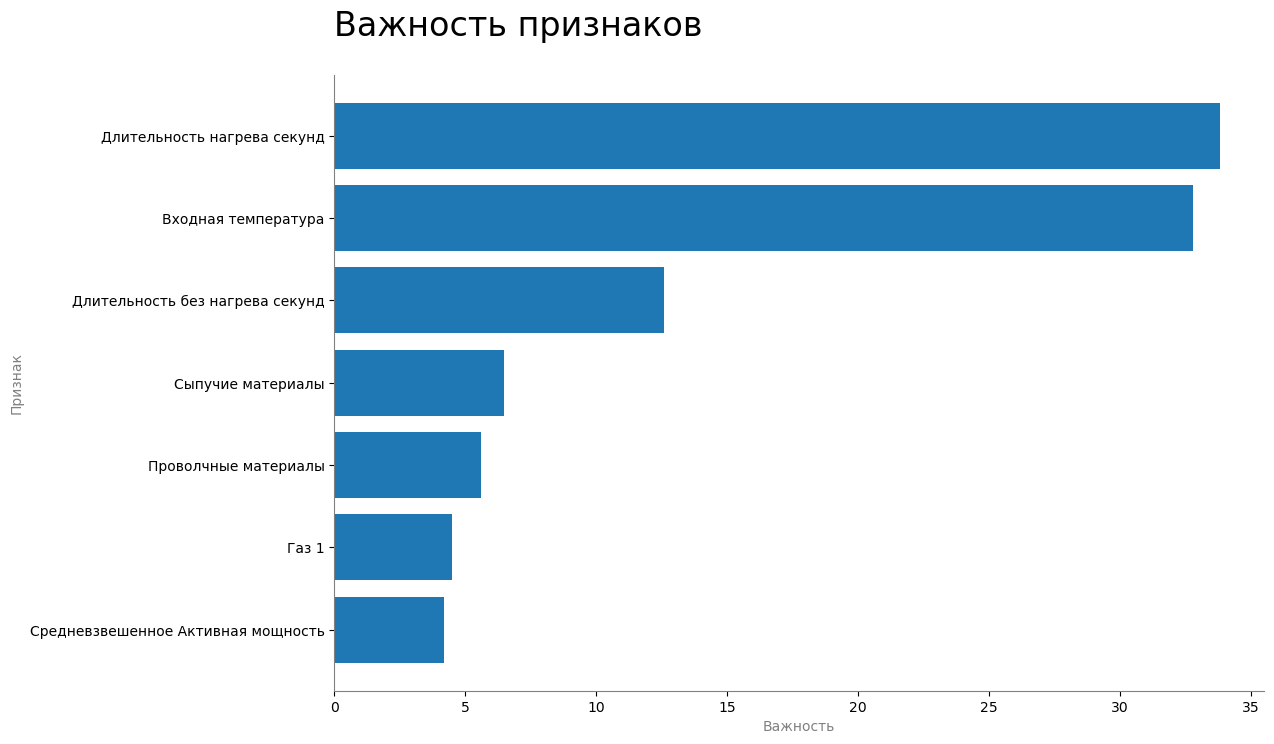

In [149]:
# визуализация важности признаков

feature_importance_func(model_coef = cat_grid_search.best_estimator_.feature_importances_)

Наиболее важные признаки такие же как у модели линейной регрессии

# Проверка лучшей модели на тестовой выборке

In [150]:
lr_pipe.fit(X_train, y_train)

lr_predict = lr_pipe.predict(X_test)
lr_result = mean_absolute_error(y_test, lr_predict)
print(f'результат модели линейной регрессии на тестовой выборке: {lr_result:.2f}')

результат модели линейной регрессии на тестовой выборке: 6.87


In [151]:
cat_predict = cat_grid_search.predict(X_test)
cat_result = mean_absolute_error(y_test, cat_predict)
print(f'результат модели градиентного бустинга на тестовой выборке: {cat_result:.2f}')

результат модели градиентного бустинга на тестовой выборке: 6.58


/Users/maks/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


# Выводы

В рамках оптимизации производственных расходов, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить прототип модели, которая предскажет температуру стали,

__Цель__: <br/>
1 Оптимизация производственных расходов. <br/>
1.1 Уменьшение потребления электроэнергии на этапе обработки стали. <br/>
_Задачи:_ <br/>
1.1.1 Построение прототипа модели, которая будет предсказывать температуру стали.

__Критерии качества:__
- MAE $\le $ 6.8;
- требований к скорости обучения и предсказания не задано;
- требований к интерпретируемости модели не задано.

__Основные этапы:__
1. _Загрузка данных._ <br/>
Были загружены данные:
- data_arc_new - данные об электродах;
- data_bulk_new - данные о подаче сыпучих материалов (объём);
- data_bulk_time_new - данные о подаче сыпучих материалов (время);
- data_gas_new - данные о продувке сплава газом;
- data_temp_new - результаты измерения температуры;
- data_wire_new - данные о проволочных материалах (объём);
- data_wire_time_new - данные о проволочных материалах (время). <br/>

Удалось загрузить все предоставленные данные<br/>

---

2. _Исследовательский анализ данных_ <br/>
_Были выявлены:_ <br/>
Качество данных:<br/>
- пропуски в данных (удалены на этапе подготовки признаков);
- отсутсвие дублей;
- аномалии (удалены аномалии: температура стали (на входе) < 1400, реактивная мощность < 0)
- несовпадение партий продукций в различных источниках данных (на этапе подготовки признаков оставили только партии по которым есть все необходимые данные)

Связи/закономерности:<br/>
- рост общего времени нагрева с ростом количества итераций;
- сильная корреляция между активной и реактивной мощностями.

---

3. _Подготовка признаков_ <br/>
Были сформированы обучающие признаки:
- температура на входе;
- общая длительность нагрева (партии);
- время без нагрева (партии);
- средняя активная мощность. Ввиду сильной корреляции активной и реактивной мощностей, и т.к. на нагрев влияет активная мощность, реактивная мощность была исключена из обучающих признаков;
- сыпучие материалы. Были агрегированы в один признак, просуммировано значение по партиям;
- проволочные материалы. Были агрегированы в один признак, просуммировано значение по партиям;
- продувка сплава газом; <br/>

Целевой признак:
- температура на выходе.

---

4. _Обучение моделей_ <br/>
Для обучения моделей использовался гиперпараметр random_state = 280823

4.1 Базовая модель. Значение MAE = 8.0;<br/>
4.2 Линейная модель. Значение MAE = 6.4 <br/>
Наиболее важные признаки:
- Длительность нагрева;
- Входная температура;
- Длительность без нагрева. <br/>
4.3 К-ближайших соседей. Значение MAE = 7.74 <br/>
Важность признаков моделью не определяется.<br/>
4.4 Градиентный бустинг (CatBoost).Значение на MAE = 6.17 <br/>
Наиболее важные признаки:
- Длительность нагрева;
- Входная температура;
- Длительность без нагрева. <br/>

Пороговое значение MAE преодолели две модели: Линейная модель, градиентный бустинг. Лучшее значение показала модель градиентного бустинга, однако, разница составляет 3.7%, при этом линейна модель обладает лучшей скоростью обучения и предсказания, а также лучшей интерпертируемостью, поэтому на тесте проверим обе модели.

---

__Значения на тесте__:
- Линейная моделль: 6.87;
- Градиентый бустинг: 6.58. <br/>
Линейная модель не преодолела пороговое значение метрики. Рекомендована модель градиентного бустинга. <br/>

---

__Гиперпараметры__:
- подбирался гиперпараметр модели 'depth' в диапазоне от 2 до 10 с шагом 2. Подобранное значение - 4

---

__Рекомендации по улучшению модели__<br/>
Была выявлена относительно большая дисперсия в обучающих признаках, что может говорить о различиях в исходном сырье и различных технологических процессах. Следует вернуться к этапу сбора данных и уточнить имеют ли место быть соответсвующие отличия. Также следует выяснить стандартизованность процесса и допуски при контроле качества.